In [ ]:
#I used the following link for this part: https://www.youtube.com/watch?v=afNuE5z2CQ8

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
import random


In [2]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

In [5]:
class Rotate_Image(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        angle = random.random() * 360
        rotated_image = transforms.functional.rotate(image, angle)
        rotated_image_90 = transforms.functional.rotate(image, 90)# to make it horizental!!
        # if you want initial imahe, instead of rotated_image_90 return image!
        return rotated_image, rotated_image_90


In [6]:
train_rotated_dataset = Rotate_Image(train_dataset)
val_rotated_dataset = Rotate_Image(val_dataset)
test_rotated_dataset = Rotate_Image(test_dataset)

train_rotated_loader = DataLoader(train_rotated_dataset, batch_size=32, shuffle=True)
val_rotated_loader = DataLoader(val_rotated_dataset, batch_size=32)
test_rotated_loader = DataLoader(test_rotated_dataset, batch_size=32)

In [7]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc31 = nn.Linear(h_dim1, z_dim)
        self.fc32 = nn.Linear(h_dim1, z_dim)

        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        return self.fc31(h), self.fc32(h) 
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

In [10]:
vae = VAE(x_dim=784, h_dim1= 512, z_dim=256)
vae.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc31): Linear(in_features=512, out_features=256, bias=True)
  (fc32): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [11]:
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)

In [12]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [13]:
def train_vae(model, train_loader, val_loader, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, image) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, image.to(device), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (data, image) in enumerate(val_loader):
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                val_loss += loss_function(recon_batch, image.to(device), mu, logvar).item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, val_loss))

    return train_losses, val_losses

In [14]:
train_losse, val_losse = train_vae(vae, train_rotated_loader, val_rotated_loader, optimizer, 10, device)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 188.381199 	Validation Loss: 175.503676
Epoch: 1 	Training Loss: 171.031544 	Validation Loss: 166.024439
Epoch: 2 	Training Loss: 162.852726 	Validation Loss: 159.695373
Epoch: 3 	Training Loss: 157.148878 	Validation Loss: 154.088514
Epoch: 4 	Training Loss: 152.877713 	Validation Loss: 150.991190
Epoch: 5 	Training Loss: 150.197091 	Validation Loss: 149.325062
Epoch: 6 	Training Loss: 148.169719 	Validation Loss: 147.703881
Epoch: 7 	Training Loss: 146.838111 	Validation Loss: 146.750259
Epoch: 8 	Training Loss: 145.903613 	Validation Loss: 145.463049
Epoch: 9 	Training Loss: 144.964739 	Validation Loss: 145.485431


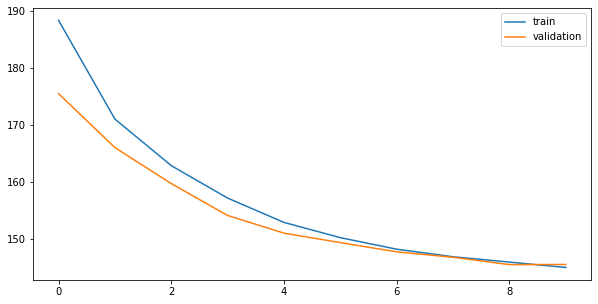

In [15]:
#plot_losses(train_losses, val_losses)
plt.figure(figsize=(10, 5))

plt.plot(train_losse, label='train')
plt.plot(val_losse, label='validation')

plt.legend()
plt.show()

torch.Size([32, 1, 28, 28])


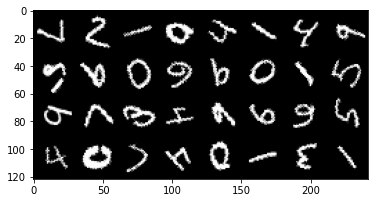

torch.Size([32, 784])
torch.Size([32, 1, 28, 28])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


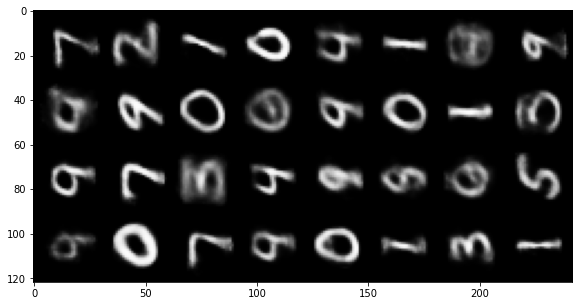

In [18]:
vae.eval()
with torch.no_grad():
    data, _ = next(iter(test_rotated_loader))
    data = data.to(device)
    print(data.shape)
    plt.imshow(torchvision.utils.make_grid(data.cpu()).permute(1, 2, 0)[...,:3])
    plt.show()
    recon_batch, _, _ = vae(data)
    print(recon_batch.shape)
    recon_batch = recon_batch.view(-1, 1, 28, 28)
    print(recon_batch.shape)
    comparison = torch.cat([data[:8], recon_batch[:8]])
    plt.figure(figsize=(10, 5))
    plt.imshow(torchvision.utils.make_grid(recon_batch.cpu()).permute(1, 2, 0)[...,:3])
    plt.show()